In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  
from sklearn.metrics import classification_report,roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, MaxAbsScaler
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import set_config
from sklearn.feature_selection import RFECV, RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import xgboost as xgb #xgb.XGBClassifier
import lightgbm as lgb #lgb.LGBMClassifier

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Read HRV Features dataset

In [4]:
# 1. Load the dataset
dff = pd.read_csv('~/AWS S3 Buckets/data_output/features_manual_combined.csv', sep=';')
#dff = pd.read_csv('~/AWS S3 Buckets/data_output/features_act_tfresh.csv', sep=',')
dfi = pd.read_csv('~/AWS S3 Buckets/patient_info.csv', sep=';')
#dfmm = pd.read_csv('~/AWS S3 Buckets/kfold_metrics.csv', sep=';')

### Data Exploration

In [5]:
# Recheck NaN percentages in the dataframe
# Large percentages have now disappeared
dff.loc[:,dff.isnull().mean()*100>0]

""
0
1
2
3
4
...
75
76
77
78


In [6]:
dff[dff.columns[dff.isnull().any()]].isnull().sum() * 100 / dff.shape[0]

Series([], dtype: float64)

In [7]:
#dff.fillna(0,inplace=True)

In [8]:
dff[dff.columns[dff.isnull().any()]].isnull().sum() * 100 / dff.shape[0]

Series([], dtype: float64)

In [9]:
dfi[dfi.columns[dfi.isnull().any()]].isnull().sum() * 100 / dfi.shape[0]

ACC_TIME                  17.475728
ACC_DAYS                  17.475728
HRV_TIME                  22.330097
HRV_HOURS                 22.330097
WURS                       4.854369
ASRS                       6.796117
MADRS                     12.621359
HADS_A                    14.563107
HADS_D                    14.563107
MED_Antidepr              81.553398
MED_Moodstab              94.174757
MED_Antipsych             97.087379
MED_Anxiety_Benzo         92.233010
MED_Sleep                 97.087379
MED_Analgesics_Opioids    98.058252
MED_Stimulants            99.029126
dtype: float64

In [10]:
dfi.isnull().mean()*100

ID                         0.000000
SEX                        0.000000
AGE                        0.000000
ACC                        0.000000
ACC_TIME                  17.475728
ACC_DAYS                  17.475728
HRV                        0.000000
HRV_TIME                  22.330097
HRV_HOURS                 22.330097
CPT_II                     0.000000
ADHD                       0.000000
ADD                        0.000000
BIPOLAR                    0.000000
UNIPOLAR                   0.000000
ANXIETY                    0.000000
SUBSTANCE                  0.000000
OTHER                      0.000000
CT                         0.000000
MDQ_POS                    0.000000
WURS                       4.854369
ASRS                       6.796117
MADRS                     12.621359
HADS_A                    14.563107
HADS_D                    14.563107
MED                        0.000000
MED_Antidepr              81.553398
MED_Moodstab              94.174757
MED_Antipsych             97

In [11]:
#dfi.fillna(0,inplace=True)

In [12]:
#dff.isin([np.inf, -np.inf]) 
#print column names where infinity is present
dff.columns.to_series()[np.isinf(dff).any()]

Series([], dtype: object)

In [13]:
# counting infinity in the dataframe 
count = np.isinf(dff).values.sum() 
print("df contains " + str(count) + " infinite values") 

df contains 0 infinite values


In [14]:
dfi['ACC_TIME'] = dfi['ACC_TIME'].apply(pd.to_datetime, format='%H:%M:%S', errors='coerce')
dfi['HRV_TIME'] = dfi['HRV_TIME'].apply(pd.to_datetime, format='%H:%M:%S', errors='coerce')
# dfi['ACC_TIME'] = pd.to_datetime(dfi.ACC_TIME, format='%H:%M:%S').dt.time[:] ?
# dfi['HRV_TIME'] = pd.to_datetime(dfi.HRV_TIME, format='%H:%M:%S').dt.time[:] ?

In [15]:
dfi['ACC_TIME_H'] = dfi['ACC_TIME'].dt.hour
dfi['HRV_TIME_H'] = dfi['HRV_TIME'].dt.hour
dfi['ACC_TIME_M'] = dfi['ACC_TIME'].dt.minute
dfi['HRV_TIME_M'] = dfi['HRV_TIME'].dt.minute

In [16]:
dfi['ACC_TIME'] = dfi.ACC_TIME.dt.strftime('%H:%M')
dfi['HRV_TIME'] = dfi.HRV_TIME.dt.strftime('%H:%M')

In [17]:
dfi.head(5)

,ID,SEX,AGE,ACC,ACC_TIME,ACC_DAYS,HRV,HRV_TIME,HRV_HOURS,CPT_II,...,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$,ACC_TIME_H,HRV_TIME_H,ACC_TIME_M,HRV_TIME_M
0,1,0,3,1,16:00,6.0,1,11:00,21.0,0,...,NaN,NaN,NaN,NaN,NaN,1,16.0,11.0,0.0,0.0
1,2,0,4,1,10:54,6.8,0,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,1,10.0,NaN,54.0,NaN
2,3,1,2,1,15:28,7.2,1,15:25,21.0,1,...,NaN,NaN,NaN,NaN,NaN,1,15.0,15.0,28.0,25.0
3,4,1,3,0,NaN,NaN,1,16:55,22.0,1,...,NaN,1.0,NaN,1.0,NaN,0,NaN,16.0,NaN,55.0
4,5,1,1,1,14:24,5.9,1,16:00,12.0,1,...,NaN,NaN,NaN,NaN,NaN,1,14.0,16.0,24.0,0.0


In [18]:
dfi['ACC_TIME'].iloc[0]

'16:00'

In [19]:
type(dfi['ACC_TIME'].iloc[0])

str

## Data Wranglling: Check for Class Imbalances

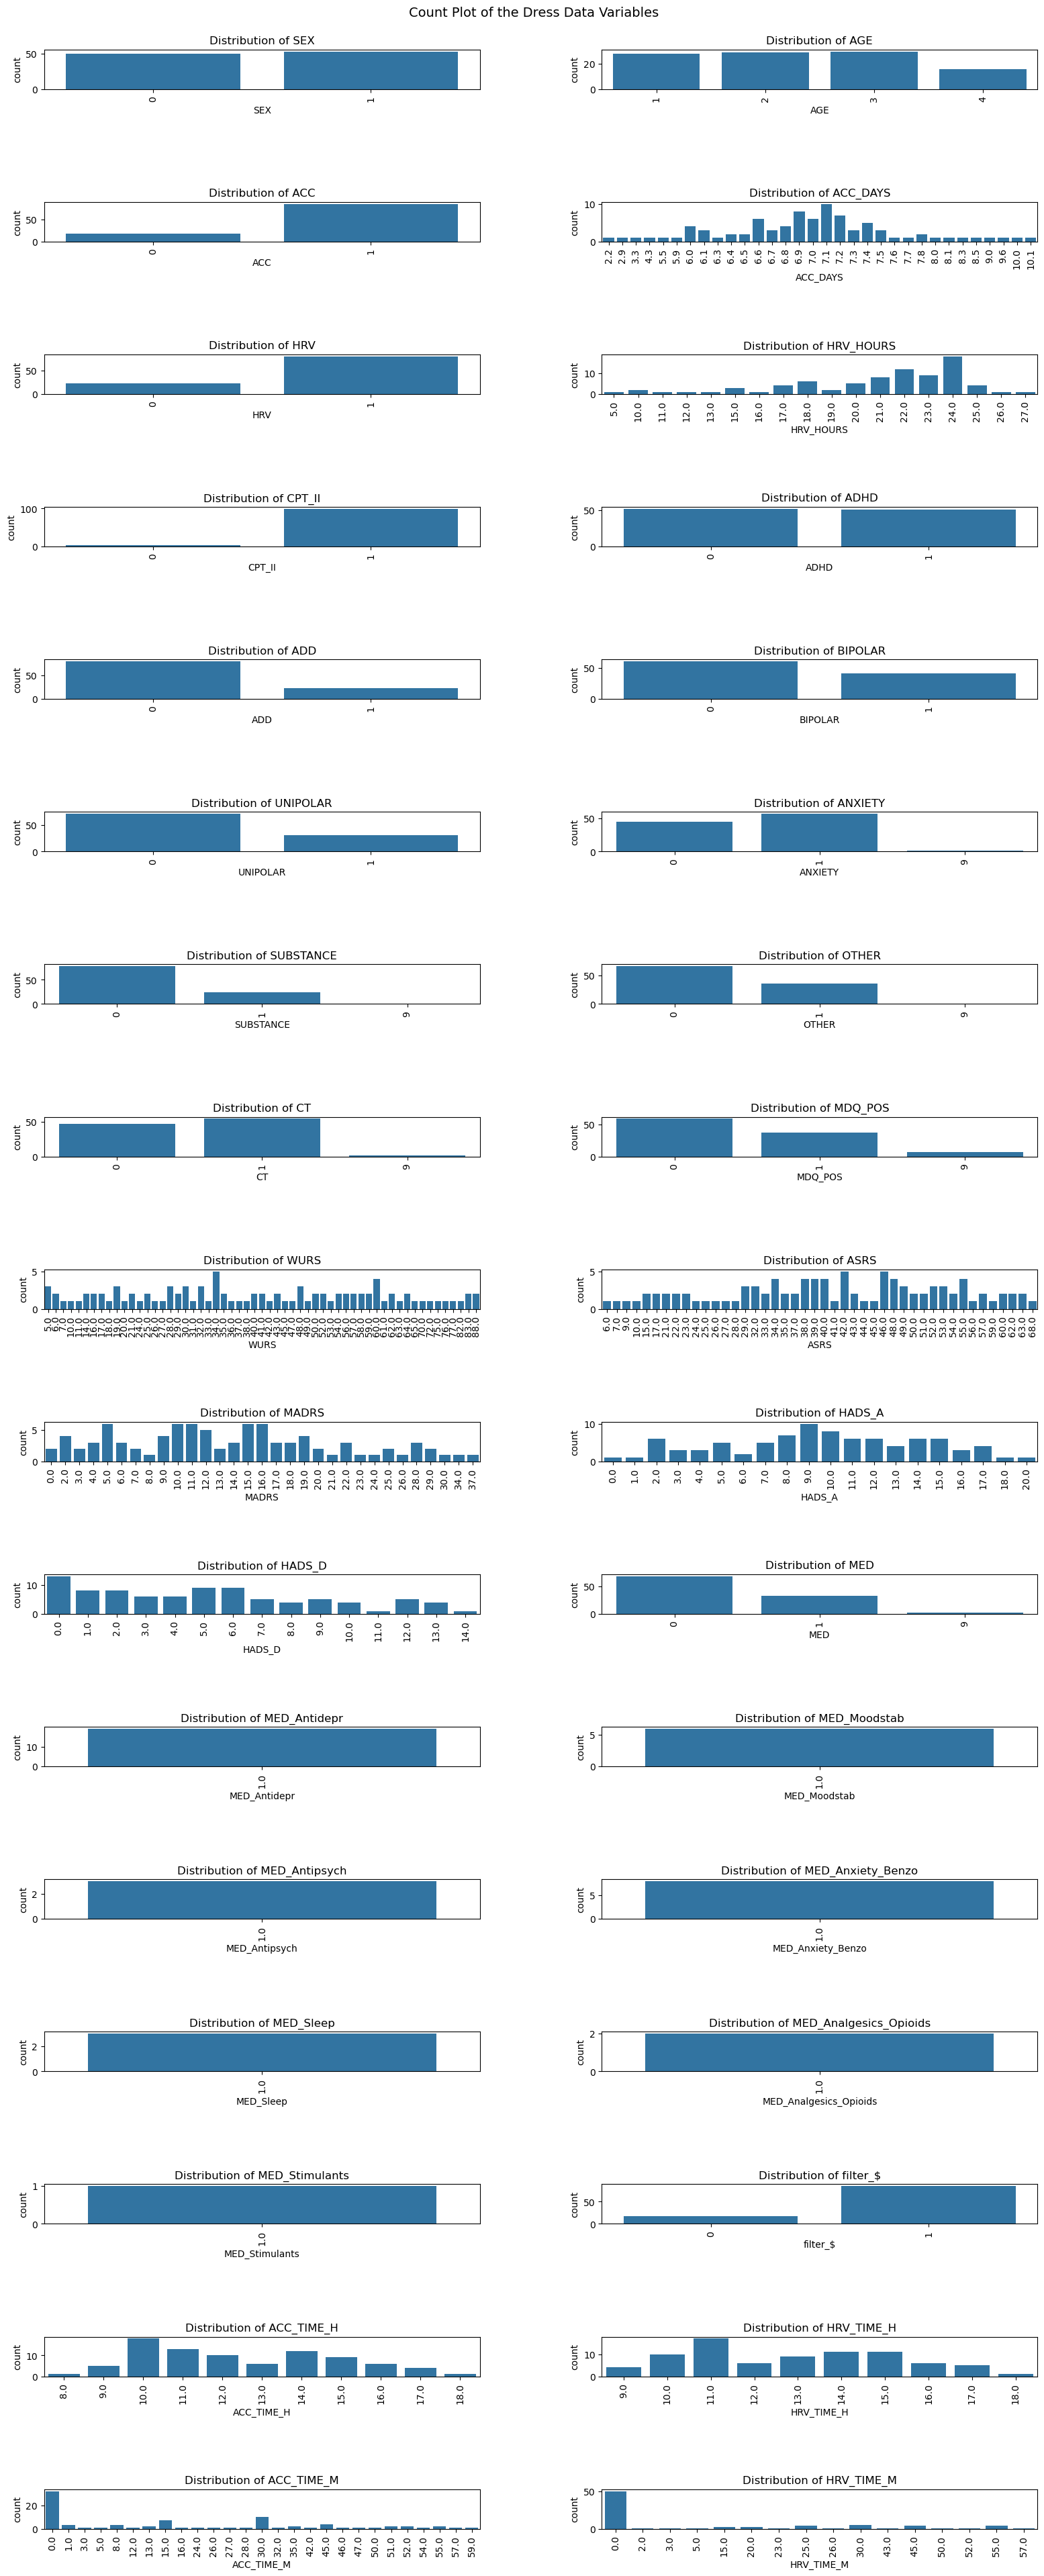

In [21]:
# Do a visual check of the data, value distributions and annomalities
import matplotlib.dates as mdates
from datetime import time

#sns.set_theme()

# filter out unnecessary columns for plotting and make copy
dfip = dfi.loc[:, ~dfi.columns.isin(['ID','ACC_TIME','HRV_TIME'])]

# Determine the number of subplot rows/columns
n = len(dfip.columns)
ncols = 2
nrows = n // ncols + (n % ncols > 0)

# Create subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 40))
fig.tight_layout(pad=10.0)
fig.suptitle("Count Plot of the Dress Data Variables", fontsize=14)

# Flatten the axs array to iterate through
axs = axs.flatten()

# Plot each categorical column in consective plots
for i, column in enumerate(dfip.columns):
    if column != "ACC_TIME" and column != 'HRV_TIME' and column != 'ID':
        sns.countplot(x=column, data=dfi, ax=axs[i])
        axs[i].set_title(f'Distribution of {column}')
        axs[i].tick_params(axis='x',rotation=90)
#     if column == "ACC_TIME" or column == 'HRV_TIME':
#         sns.countplot(x=column, data=dfi, ax=axs[i])
        #axs[i].set_xlim(dfi[''], df.index[-1])
        #axs[i].xaxis.set_major_locator(mdates.HourLocator())
        #axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
        #axs[i].tick_params(axis="x", rotation=45)

# Hide any unused subplots
for ax in axs[i+1:]:
    ax.set_visible(False)

plt.show();

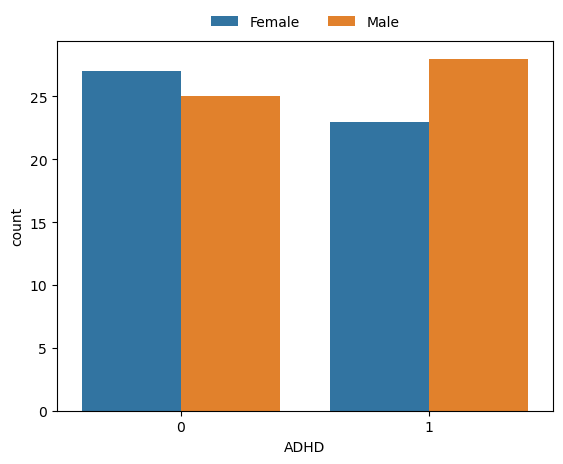

In [105]:
# Check if ADHS is more prevalent in males
#0: female, 1 male
di_sex={0:'Female',1:'Male'}

ax = sns.countplot(data=dfi.replace({'SEX':di_sex}), x="ADHD", hue='SEX')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [106]:
# There are more 0 Recommendation vs 1 Recommendations, which is our target variable. This imbalance can be addressed in the sampling stage.
# There is an overweight on Ratings = 0 vs the rest of the class. This imbalance can be addressed in the sampling stage.


### Sample Data and Split into Training and Test Sets

In [107]:
# need to be on scikit-learn 0.24.0 or above
# The scikit-learn version used is 1.2.2.
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.0.


In [108]:
dfi.columns

Index(['ID', 'SEX', 'AGE', 'ACC', 'ACC_TIME', 'ACC_DAYS', 'HRV', 'HRV_TIME',
       'HRV_HOURS', 'CPT_II', 'ADHD', 'ADD', 'BIPOLAR', 'UNIPOLAR', 'ANXIETY',
       'SUBSTANCE', 'OTHER', 'CT', 'MDQ_POS', 'WURS', 'ASRS', 'MADRS',
       'HADS_A', 'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab',
       'MED_Antipsych', 'MED_Anxiety_Benzo', 'MED_Sleep',
       'MED_Analgesics_Opioids', 'MED_Stimulants', 'filter_$', 'ACC_TIME_H',
       'HRV_TIME_H', 'ACC_TIME_M', 'HRV_TIME_M'],
      dtype='object')

In [109]:
dff.columns

Index(['ID', 'HRV__sum_values', 'HRV__median', 'HRV__mean', 'HRV__length',
       'HRV__standard_deviation', 'HRV__variance', 'HRV__root_mean_square',
       'HRV__maximum', 'HRV__absolute_maximum', 'HRV__minimum',
       '25th_percentile_HRV', '50th_percentile_HRV', '75th_percentile_HRV',
       'skewness_HRV', 'kurtosis_HRV', 'above_mean_HRV', 'below_mean_HRV',
       'range_HRV', 'iqr_HRV', 'mad_HRV', 'medad_HRV', 'rms_HRV', 'cv_HRV',
       'md_HRV', 'msd_HRV', 'rmssd_HRV', 'vlf_power_HRV', 'lf_power_HRV',
       'hf_power_HRV', 'lf_hf_ratio_HRV', 'peak_frequency_HRV',
       'total_power_HRV', 'nn50_HRV', 'pnn50_HRV', 'slope_time_HRV',
       'intercept_time_HRV', 'correlation_time_HRV',
       'p_value_correlation_time_HRV', 'std_err_slope_time_HRV'],
      dtype='object')

In [110]:
dff.dtypes

ID                                int64
HRV__sum_values                 float64
HRV__median                     float64
HRV__mean                       float64
HRV__length                     float64
HRV__standard_deviation         float64
HRV__variance                   float64
HRV__root_mean_square           float64
HRV__maximum                    float64
HRV__absolute_maximum           float64
HRV__minimum                    float64
25th_percentile_HRV             float64
50th_percentile_HRV             float64
75th_percentile_HRV             float64
skewness_HRV                    float64
kurtosis_HRV                    float64
above_mean_HRV                  float64
below_mean_HRV                  float64
range_HRV                       float64
iqr_HRV                         float64
mad_HRV                         float64
medad_HRV                       float64
rms_HRV                         float64
cv_HRV                          float64
md_HRV                          float64


In [112]:
# columns with 1 unique value.
dfi['MED_Antidepr'].nunique(dropna=True)
dfi['MED_Antidepr'].unique()

1

array([ 1., nan])

In [113]:
# Use dff
# Split data dff into training and testing sets.

import re

# dff = dff.fillna(0)
# y = y.fillna(0)

# Remove JSON symbols from headers
dff = dff.rename(columns = lambda x:re.sub('"', '', x))
dff = dff.rename(columns = lambda x:re.sub(',', '', x))
dff = dff.rename(columns = lambda x:re.sub('"', '', x))
dff = dff.rename(columns = lambda x:re.sub(',', '', x))

# Match X and Y data
dfi = dfi[dfi["ID"].isin(dff["ID"])].sort_values(by="ID")
dff = dff[dff["ID"].isin(dfi["ID"])].sort_values(by="ID")

dff = dff.set_index("ID")
dfi = dfi.set_index("ID")

# Adding SEX to features data set for inclusion in prediction algorithms
#dataX = dataX.merge(dataY[["SEX"]], on="ID", how="left")
#dataX = dataX.merge(dataY[["HRV", "HRV_TIME", "HRV_HOURS"]], on="ID", how="left")
#pd.merge(dataX, dataY[["HRV", "HRV_TIME", "HRV_HOURS"]], on="ID", how="left")

# dataX = dataX.fillna(0)
# dataY = dataY.fillna(0)

dff.index.name = None
dfi.index.name = None

y = dfi.loc[:, dfi.columns.isin(['ADHD'])].copy(deep=True)
x = dff.copy(deep=True)

type(x), type(y)
x.head(5)
y.head(5)

# split the data into test and training sets
# stratify addresses imbalance in the y variable.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
len(x_train), len(x_test), len(y_train), len(y_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

,HRV__sum_values,HRV__median,HRV__mean,HRV__length,HRV__standard_deviation,HRV__variance,HRV__root_mean_square,HRV__maximum,HRV__absolute_maximum,HRV__minimum,...,lf_hf_ratio_HRV,peak_frequency_HRV,total_power_HRV,nn50_HRV,pnn50_HRV,slope_time_HRV,intercept_time_HRV,correlation_time_HRV,p_value_correlation_time_HRV,std_err_slope_time_HRV
1,76054282.86,701.17,707.652854,107474.0,139.830143,19552.468961,721.335588,2697.27,2697.27,323.24,...,1.529228,0.015625,4.437704e+05,10207.0,0.094972,-0.000170,2.103045e+05,-0.026657,2.318335e-18,0.000019
3,75202557.64,740.23,759.529730,99012.0,158.315575,25063.821306,775.853873,2469.73,2469.73,191.41,...,0.742440,0.015625,7.515955e+05,15367.0,0.155203,0.002678,-3.306995e+06,0.376565,0.000000e+00,0.000021
4,78466434.18,839.84,768.352224,102123.0,302.063269,91242.218702,825.595154,2892.58,2892.58,108.40,...,1.599464,0.015625,9.560329e+05,18961.0,0.185668,-0.006275,7.766233e+06,-0.499847,0.000000e+00,0.000034
5,77265319.09,825.20,1003.211186,77018.0,486.849615,237022.547524,1115.103238,3062.50,3062.50,188.48,...,0.813481,0.015625,3.199768e+06,25679.0,0.333416,0.016910,-2.089109e+07,0.715116,0.000000e+00,0.000060
7,76822253.59,833.98,828.531332,92721.0,188.032551,35356.240267,849.600146,3033.20,3033.20,192.38,...,1.190172,0.015625,1.117356e+06,27560.0,0.297236,0.002534,-3.133269e+06,0.295416,0.000000e+00,0.000027


,ADHD
1,1
3,1
4,1
5,1
7,0


(64, 16, 64, 16)

In [114]:
x.iloc[[0, 2, 4, 29, 35, 47, 49, 56]]

,HRV__sum_values,HRV__median,HRV__mean,HRV__length,HRV__standard_deviation,HRV__variance,HRV__root_mean_square,HRV__maximum,HRV__absolute_maximum,HRV__minimum,...,lf_hf_ratio_HRV,peak_frequency_HRV,total_power_HRV,nn50_HRV,pnn50_HRV,slope_time_HRV,intercept_time_HRV,correlation_time_HRV,p_value_correlation_time_HRV,std_err_slope_time_HRV
1,76054282.86,701.17,707.652854,107474.0,139.830143,19552.468961,721.335588,2697.27,2697.27,323.24,...,1.529228,0.015625,4.437704e+05,10207.0,0.094972,-0.000170,2.103045e+05,-0.026657,2.318335e-18,0.000019
4,78466434.18,839.84,768.352224,102123.0,302.063269,91242.218702,825.595154,2892.58,2892.58,108.40,...,1.599464,0.015625,9.560329e+05,18961.0,0.185668,-0.006275,7.766233e+06,-0.499847,0.000000e+00,0.000034
7,76822253.59,833.98,828.531332,92721.0,188.032551,35356.240267,849.600146,3033.20,3033.20,192.38,...,1.190172,0.015625,1.117356e+06,27560.0,0.297236,0.002534,-3.133269e+06,0.295416,0.000000e+00,0.000027
41,72604173.05,641.60,650.440976,111623.0,126.412245,15980.055626,662.611137,2676.76,2676.76,223.63,...,1.619053,0.015625,2.756618e+05,7631.0,0.068364,0.002139,-2.695641e+06,0.353967,0.000000e+00,0.000017
47,73360400.50,781.25,841.279349,87201.0,276.935325,76693.174366,885.688499,3051.76,3051.76,193.36,...,0.968802,0.015625,1.619445e+06,20855.0,0.239160,0.000102,-1.283993e+05,0.007246,3.237853e-02,0.000048
60,87085023.81,982.42,1023.361855,85097.0,312.541306,97682.068205,1070.024091,5000.00,5000.00,177.73,...,1.188614,0.015625,2.082319e+06,37637.0,0.442284,0.004403,-5.598352e+06,0.366670,0.000000e+00,0.000038
63,41720326.48,572.27,531.977386,78425.0,286.481996,82071.933978,604.211778,2977.54,2977.54,92.77,...,0.842340,0.015625,1.703113e+06,27079.0,0.345285,0.002965,-3.775127e+06,0.129393,6.539095e-290,0.000081
75,85212525.34,870.12,966.139359,88199.0,382.508972,146313.114039,1039.104603,3153.32,3153.32,193.36,...,1.160939,0.015625,2.208391e+06,34428.0,0.390345,0.001202,-1.545512e+06,0.082442,7.948335e-133,0.000049


In [115]:
y.iloc[[0, 2, 4, 29, 35, 47, 49, 56]]

,ADHD
1,1
4,1
7,0
41,1
47,0
60,1
63,1
75,1


In [52]:
ordinal_columns = []
nominal_columns = []
numerical_columns = []

for series_name, series in x.items():
    if x[series_name].nunique(dropna=True) == 1 and x[series_name].unique()[0] == 1:
        #dfi[series_name].fillna(0, inplace=True)
        x[series_name] = x[series_name].apply(str).fillna('0')
        nominal_columns.append(series_name)
    elif x[series_name].nunique(dropna=True) == 2 and 1 in x[series_name].unique() and 0 in x[series_name].unique():
        x[series_name] = x[series_name].apply(str).fillna('0')
        nominal_columns.append(series_name)
    elif series_name == 'AGE':
        x[series_name].apply(str).fillna('0')
        ordinal_columns.append(series_name)
    elif series_name == 'ACC_TIME' or series_name == 'HRV_TIME':
        x.drop(series_name, inplace=True, axis=1)
    elif x[series_name].dtype in ['int64','float64']:
        numerical_columns.append(series_name)

ordinal_columns
nominal_columns
numerical_columns

[]

[]

['HRV__sum_values',
 'HRV__median',
 'HRV__mean',
 'HRV__length',
 'HRV__standard_deviation',
 'HRV__variance',
 'HRV__root_mean_square',
 'HRV__maximum',
 'HRV__absolute_maximum',
 'HRV__minimum',
 '25th_percentile_HRV',
 '50th_percentile_HRV',
 '75th_percentile_HRV',
 'skewness_HRV',
 'kurtosis_HRV',
 'above_mean_HRV',
 'below_mean_HRV',
 'range_HRV',
 'iqr_HRV',
 'mad_HRV',
 'medad_HRV',
 'rms_HRV',
 'cv_HRV',
 'md_HRV',
 'msd_HRV',
 'rmssd_HRV',
 'vlf_power_HRV',
 'lf_power_HRV',
 'hf_power_HRV',
 'lf_hf_ratio_HRV',
 'peak_frequency_HRV',
 'total_power_HRV',
 'nn50_HRV',
 'pnn50_HRV',
 'slope_time_HRV',
 'intercept_time_HRV',
 'correlation_time_HRV',
 'p_value_correlation_time_HRV',
 'std_err_slope_time_HRV']

In [53]:
y['ADHD'].unique()#[1]

array([1, 0])

### Prepare the Training Pipelines

In [56]:
# Create ordered lists for those ordinal values
age_ordered_categories = ['1', '2', '3','4']


In [57]:
# NaN is usually used as the placeholder for missing values. However, it enforces the data type to be float. 
# The parameter missing_values allows to specify other placeholder such as integer or text


In [58]:
# Define the ordinal categorical pipeline processing steps
# RandomForestClassifier()
# IterativeImputer(estimator=BayesianRidge(), initial_strategy='most_frequent', max_iter=10, random_state=0)
ordinal_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant', fill_value=0)), #(strategy='constant', fill_value='missing' or =0) or (strategy='most_frequent')
          ("encoder", OrdinalEncoder(categories=[age_ordered_categories], handle_unknown="use_encoded_value", unknown_value=-999)),
          ("scaler", MinMaxScaler())]
)

# Define the nominal categorical pipeline processing steps
nominal_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant', fill_value=0)), #(strategy='constant', fill_value='missing') or (strategy='most_frequent')
          ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=1, drop='first')),#, sparse_output=False
          ("scaler", MaxAbsScaler())] #vs MinMaxScaler()
)

# Define the numeric categorical pipeline processing steps
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=1, weights='distance')), #another option is defining missing_values=0, or treat 0 a category of its own.
           ("scaler", MaxAbsScaler())] #vs MinMaxScaler()
)

# Construct the processor with combined pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("ord_categoricals", ordinal_transformer, ordinal_columns),
        ("nom_categoricals", nominal_transformer, nominal_columns),
        ("numeric", numeric_transformer, numerical_columns)], 
        remainder='passthrough'
)

feature_selector = RFECV(estimator=GradientBoostingClassifier())

In [59]:
# examine pipeline encoding values properly
pipeline = Pipeline([("preprocessor", preprocessor)])
                    
fitted_pipeline = pipeline.fit_transform(x_train)                  
fitted_pipeline

array([[ 5.94286540e-01,  3.58400000e-01,  5.35014259e-01, ...,
         3.71719135e-01,  0.00000000e+00,  2.08912148e-01],
       [ 5.66081735e-01,  3.22755000e-01,  5.83338299e-01, ...,
        -8.03220305e-01,  0.00000000e+00,  5.11114149e-01],
       [ 5.76624573e-01,  4.16990000e-01,  5.78745225e-01, ...,
         3.59830767e-01,  0.00000000e+00,  2.23153309e-01],
       ...,
       [ 4.89561958e-01,  2.88085000e-01,  4.00633271e-01, ...,
        -3.94985940e-01,  0.00000000e+00,  1.13490418e-01],
       [ 6.53656490e-01,  4.91210000e-01,  7.14838129e-01, ...,
         4.46621772e-01,  0.00000000e+00,  3.17498654e-01],
       [ 6.26150320e-01,  3.50585000e-01,  5.40911759e-01, ...,
         3.63939409e-02,  3.33242131e-21,  3.10612806e-01]])

In [60]:
fitted_pipeline.shape

(64, 39)

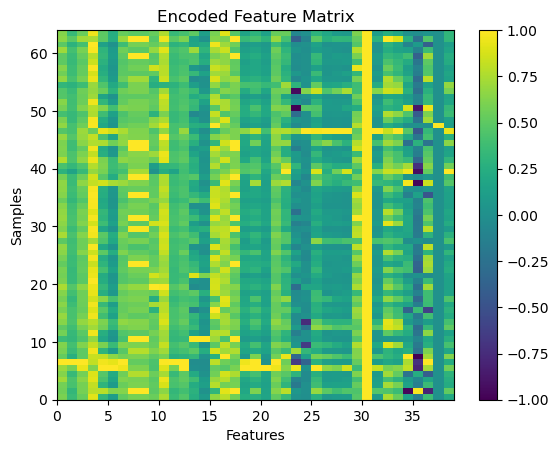

In [61]:
# Plot and visulise the encoded feature matrix

plt.pcolormesh(fitted_pipeline)
plt.xlabel('Features')
plt.ylabel('Samples')
plt.title('Encoded Feature Matrix')
plt.colorbar();

### Run the ML Training Pipeline for Different Models 

In [294]:
# initiate list of metrics:
metrics_list = []

In [341]:


_RANDOM_SEED = 0
_NUMBER_OF_FOLDS = 5
_TEST_RATIO = .30
_KFold = 6

_PARAMS_LORGREG = {
     #Valid parameters are: ['memory', 'steps', 'verbose']
    "penalty": ['l2','l1l'] , "C": [100, 10, 1.0, 0.1, 0.01, 0.001], "class_weight": ['balanced'],
    "random_state": [0], "solver": ['lbfgs', 'liblinear'], "n_jobs": [1], 
    "max_iter":[100,300,500,800,1000]
}

_PARAMS_RFC = {
    "n_estimators": [100, 200], "criterion": ['entropy'],
    "max_features": [None, 'log2', 'sqrt'], "max_depth": [None, 5, 10],
    "min_samples_split": [2], "min_samples_leaf": [1],
    "min_weight_fraction_leaf": [0.0],
    "max_leaf_nodes": [None], "bootstrap": [True],
    "oob_score": [False], "n_jobs": [-1], "random_state": [_RANDOM_SEED],
    "class_weight": ["balanced"]
}

# Define the hyperparameter grid
_PARAMS_KNN = {"n_neighbors": np.arange(1, 11),
                #'leaf_size': list(range(1,50)),
                "weights": ['uniform', 'distance'],
                "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
                #'metric' : ['minkowski','euclidean','manhattan'],
                "p": [1, 2]}

_PARAMS_XGB = {
    "random_state": [_RANDOM_SEED], 
    "verbosity": [0], "objective":['binary:logistic'], 
    "max_depth": np.arange(2, 10), #list(range (2, 10, 1))
    "n_estimators": np.arange(100, 1100, 100), #list(range(60, 220, 40)) #"n_estimators": [1000]
    "learning_rate": [0.1, 0.01, 0.05] #"learning_rate": [.01],
    #'num_leaves': [7, 14, 21, 28, 31, 50],
}

_PARAMS_LIGHTGB = param_grid = {
    "num_leaves": [7, 14, 21, 28, 31], #maximum to 2^depth - 1.
    "max_depth": [-1, 3, 5], 
    # "subsample": [0.8, 1.0],
    # "colsample_bytree": [0.8, 1.0],
    "learning_rate": [0.1, 0.03, 0.003],#[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "n_estimators": range(50,500,50)
    }




### 1- Logic Regression

In [239]:
%%time

#1
# Logistic Regession

clf = LogisticRegression() #random_state=0
pipe_lrg = Pipeline([("preprocessor", preprocessor),
                 ("selector", feature_selector), 
                 ("classifier", clf)])

# Make code modular
pipe = pipe_lrg


grid_params = {'classifier__'+k: v for k, v in _PARAMS_LORGREG.items()}
grid_search_lrg = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=_NUMBER_OF_FOLDS, n_jobs=-1, verbose=True, refit=True, scoring='r2')

# Make code modular
grid_search = grid_search_lrg

grid_search.fit(x_train, np.ravel(y_train, order='C'))


Fitting 5 folds for each of 120 candidates, totalling 600 fits
CPU times: user 26.9 s, sys: 3.03 s, total: 30 s
Wall time: 1h 4min 40s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_categoricals',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(categories=[['1',
                                                                                                                      '2',
                                                                                                                      '3',
                                                                                                                      '4']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-999)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())...
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [100, 10, 1.0, 0.1, 0.01, 0.001],
                         'classifier__class_weight': ['balanced'],
                         'classifier__max_iter': [100, 300, 500, 800, 1000],
                         'classifier__n_jobs': [1],
                         'classifier__penalty': ['l2', 'l1l'],
                         'classifier__random_state': [0],
                         'classifier__solver': ['lbfgs', 'liblinear']},
             scoring='r2', verbose=True)

In [240]:

# summarize best Estimator

print('=========================================[Best Hyperparameters info]=====================================')
print('Best Score: %.3f'  % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
print('Best_estimator:')
print(grid_search.best_estimator_)
print('==========================================================================================================')


predictions_lrg = grid_search.predict(x_test)
predictions_train_lrg = grid_search.predict(x_train)

# Make code modular
predictions = predictions_lrg
predictions_train = predictions_train_lrg

=========================================[Best Hyperparameters info]=====================================
Best Score: -0.690
Best Config: {'classifier__C': 100, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 800, 'classifier__n_jobs': 1, 'classifier__penalty': 'l2', 'classifier__random_state': 0, 'classifier__solver': 'lbfgs'}
Best_estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_categoricals',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['1',
                    

In [417]:
%%time
# cross Validate the Best Estimator model metrics

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'roc':'roc_auc',
           'mcc':'matthews_corrcoef',
           'f1':'f1',
          }

scores_lrg = cross_validate(grid_search.best_estimator_, x, np.ravel(y, order='C'), scoring=scoring, #grid_search or pipe or clf
                         cv=_KFold, return_train_score=True) #takes multiple metrics

# Make code modular
scores = scores_lrg

print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec', 'train_prec', 'test_rec', 'train_rec', 'test_roc', 'train_roc', 'test_mcc', 'train_mcc', 'test_f1', 'train_f1'])
CPU times: user 1min 45s, sys: 176 ms, total: 1min 45s
Wall time: 1min 45s


In [418]:
# check metrics list
print('train_acc: ', scores['train_acc'])
print('test_acc: ', scores['test_acc'])
print('test_prec: ', scores['test_prec'])
print('test_rec: ', scores['test_rec'])
print('test_f1: ', scores['test_f1'])
print('test_roc: ', scores['test_roc'])
print('test_mcc: ', scores['test_mcc'])

train_acc:  [0.72727273 0.81818182 0.67164179 0.74626866 0.3880597  0.71641791]
test_acc:  [0.64285714 0.5        0.46153846 0.76923077 0.76923077 0.61538462]
test_prec:  [0.75       0.5        0.42857143 0.8        0.8        0.57142857]
test_rec:  [0.42857143 0.42857143 0.5        0.66666667 0.66666667 0.66666667]
test_f1:  [0.54545455 0.46153846 0.46153846 0.72727273 0.72727273 0.61538462]
test_roc:  [0.65306122 0.51020408 0.4047619  0.83333333 0.73809524 0.61904762]
test_mcc:  [ 0.31622777  0.         -0.07142857  0.53674504  0.53674504  0.23809524]


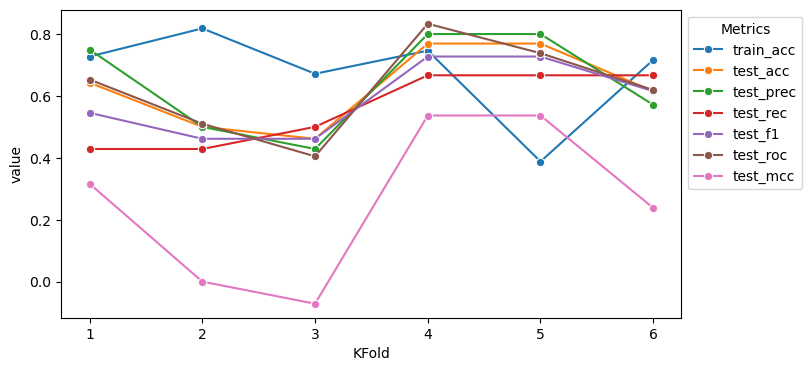

In [426]:
# Plot the Cross Validation metrics from the Best Estimator

crossVal_metrics = ['train_acc','test_acc','test_prec','test_rec','test_f1','test_roc','test_mcc']
crossVal_metrics_scores = []

# Add Kfold 
kfolds = np.arange(1, _KFold+1)
crossVal_metrics_scores.append(kfolds)


for metric in crossVal_metrics:
    #print(np.ravel(scores[metric]))
    crossVal_metrics_scores.append(scores[metric])

dfm = pd.DataFrame(zip(*crossVal_metrics_scores), columns = ['KFold']+crossVal_metrics).set_index('KFold')

#dfm.to_csv('kfold_metrics.csv', sep=';', encoding='utf-8', index=True, header=True)

dfplt = dfm.melt(ignore_index=False).reset_index()

#dfplt

# set the figure height and width
fig, ax = plt.subplots(figsize=(8, 4))

# plot with seaborn
sns.lineplot(ax=ax, data=dfplt, x='KFold', y='value', hue='variable', marker='o')
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title='Metrics')
plt.xticks(np.arange(1, _KFold+1))

plt.show();


In [427]:
# Model Evaluation Metrics Mean Scores

ml_metrics = {
    'Accuracy on Training Data':'{:.2f}'.format(np.mean(dfm['train_acc'])),#.format(pipe.score(x_train, y_train)), 
    'Accuracy on Test Data':'{:.2f}'.format(np.mean(dfm['test_acc'])),#.format(pipe.score(x_test, y_test)), 
    'Precision of Classifier on Test Data':'{:.2f}'.format(np.mean(dfm['test_prec'])),
    'Recall of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_rec'])),
    'F1 of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_f1'])),
    'ROC AUC Score of Classifier on Test Data':'{:.2f}%'.format(np.mean(dfm['test_roc'])*100),
    'MCC Coefficient': '{:.5f}'.format(np.mean(dfm['test_mcc'])),
}
df = pd.DataFrame.from_dict(ml_metrics, orient='index',
                       columns=['Logistic Regression'])
metrics_list.append(df)
df


,Logistic Regression
Accuracy on Training Data,0.68
Accuracy on Test Data,0.63
Precision of Classifier on Test Data,0.64
Recall of Classifier on Test Data,0.55952
F1 of Classifier on Test Data,0.58974
ROC AUC Score of Classifier on Test Data,62.64%
MCC Coefficient,0.25940


In [428]:
# Produce the Cross Validation Confusion Metrix

y_pred = cross_val_predict(grid_search.best_estimator_, x, np.ravel(y, order='C'), cv=_KFold)
conf_mat = confusion_matrix(y, y_pred)

conf_mat


array([[28, 14],
       [18, 20]])

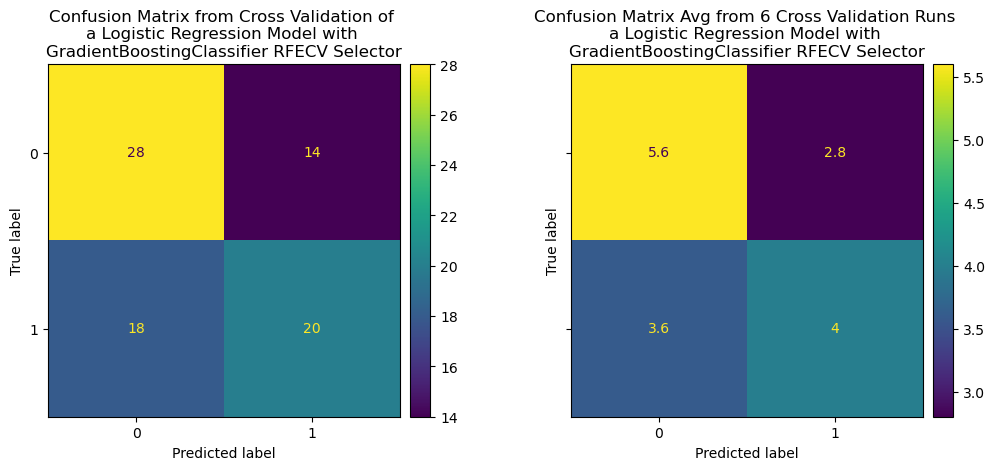

In [429]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplots(figsize=(10, 10), ncols=2, sharex=True, sharey=True)

# Plot total sum of all folds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[0], colorbar=False)
disp.ax_.set_title('Confusion Matrix from Cross Validation of \na Logistic Regression Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[0].get_position().x1+0.01, axs[0].get_position().y0, 0.02, axs[0].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

#Plot Avg values per _KFold rounds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat/(_KFold-1), display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[1], colorbar=False)
disp.ax_.set_title(f'Confusion Matrix Avg from {_KFold} Cross Validation Runs \na Logistic Regression Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[1].get_position().x1+0.01, axs[1].get_position().y0, 0.02, axs[1].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

bbox = axs[1].get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
axs[1].set_position(new_bbox)

bbox = cax.get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
cax.set_position(new_bbox)

plt.show();

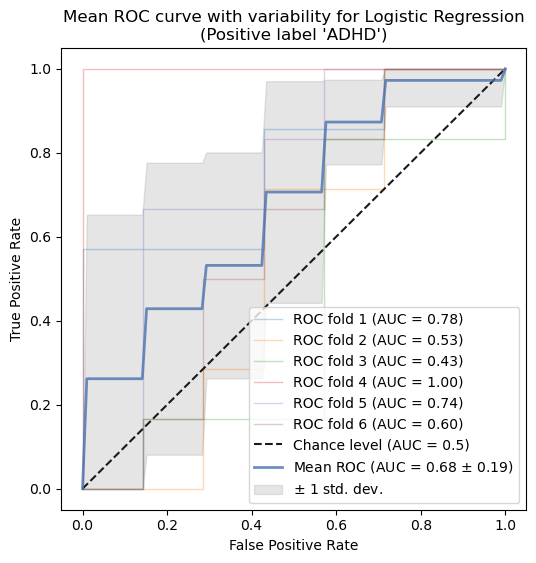

In [416]:
# Plot Cross Validation ROC AUC

classifier = grid_search.best_estimator_
n_splits = _KFold
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6)) #, nrows=7
for fold, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold+1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability for Logistic Regression\n(Positive label 'ADHD')",
)
ax.legend(loc="lower right")

# Hide any unused subplots
# ax = ax.flatten()
# for i, aax in enumerate(ax):
#     # print(i)
#     if i != 6:
#         aax.set_visible(False)
    
plt.show();

### 2- Random Forest

In [68]:
%%time

#1
# Random Forest

clf = RandomForestClassifier() #random_state=0
pipe_rfc = Pipeline([("preprocessor", preprocessor),
                 ("selector", feature_selector), 
                 ("classifier", clf)])

# Make code modular
pipe = pipe_rfc



grid_params = {'classifier__'+k: v for k, v in _PARAMS_RFC.items()}
grid_search_rfc = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=_NUMBER_OF_FOLDS, n_jobs=-1, verbose=True, refit=True, scoring='r2')

# Make code modular
grid_search = grid_search_rfc

grid_search.fit(x_train, np.ravel(y_train, order='C'))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 20.4 s, sys: 791 ms, total: 21.2 s
Wall time: 4min 43s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_categoricals',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(categories=[['1',
                                                                                                                      '2',
                                                                                                                      '3',
                                                                                                                      '4']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-999)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())...
                         'classifier__max_features': [None, 'log2', 'sqrt'],
                         'classifier__max_leaf_nodes': [None],
                         'classifier__min_samples_leaf': [1],
                         'classifier__min_samples_split': [2],
                         'classifier__min_weight_fraction_leaf': [0.0],
                         'classifier__n_estimators': [100, 200],
                         'classifier__n_jobs': [-1],
                         'classifier__oob_score': [False],
                         'classifier__random_state': [0]},
             scoring='r2', verbose=True)

In [152]:

# summarize Best Estimator
print('=========================================[Best Hyperparameters info]=====================================')
print('Best Score: %.3f'  % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
print('Best_estimator:')
print(grid_search.best_estimator_)
print('==========================================================================================================')


predictions_rfc = grid_search.predict(x_test)
predictions_train_rfc = grid_search.predict(x_train)

# Make code modular
predictions = predictions_rfc
predictions_train = predictions_train_rfc

=========================================[Best Hyperparameters info]=====================================
Best Score: -1.252
Best Config: {'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 100, 'classifier__n_jobs': -1, 'classifier__oob_score': False, 'classifier__random_state': 0}
Best_estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_categoricals',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                               

In [430]:
%%time
# cross Validate the model metrics

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'roc':'roc_auc',
           'mcc':'matthews_corrcoef',
           'f1':'f1',
          }

scores_rfc = cross_validate(grid_search.best_estimator_, x, np.ravel(y, order='C'), scoring=scoring, #grid_search or pipe or clf
                         cv=_KFold, return_train_score=True) #takes multiple metrics

# Make code modular
scores = scores_rfc

print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec', 'train_prec', 'test_rec', 'train_rec', 'test_roc', 'train_roc', 'test_mcc', 'train_mcc', 'test_f1', 'train_f1'])
CPU times: user 1min 47s, sys: 681 ms, total: 1min 47s
Wall time: 1min 47s


In [431]:
# Inspect Cross Validation Metrics score lists
print('train_acc: ',scores['train_acc'])
print('test_acc: ',scores['test_acc'])
print('test_prec: ',scores['test_prec'])
print('test_rec: ',scores['test_rec'])
print('test_f1: ',scores['test_f1'])
print('test_roc: ',scores['test_roc'])
print('test_mcc: ',scores['test_mcc'])

train_acc:  [1. 1. 1. 1. 1. 1.]
test_acc:  [0.5        0.57142857 0.30769231 0.46153846 0.30769231 0.61538462]
test_prec:  [0.5        0.57142857 0.2        0.4        0.33333333 0.55555556]
test_rec:  [0.28571429 0.57142857 0.16666667 0.33333333 0.5        0.83333333]
test_f1:  [0.36363636 0.57142857 0.18181818 0.36363636 0.4        0.66666667]
test_roc:  [0.55102041 0.43877551 0.30952381 0.5952381  0.16666667 0.70238095]
test_mcc:  [ 0.          0.14285714 -0.41475753 -0.09759001 -0.38575837  0.28288947]


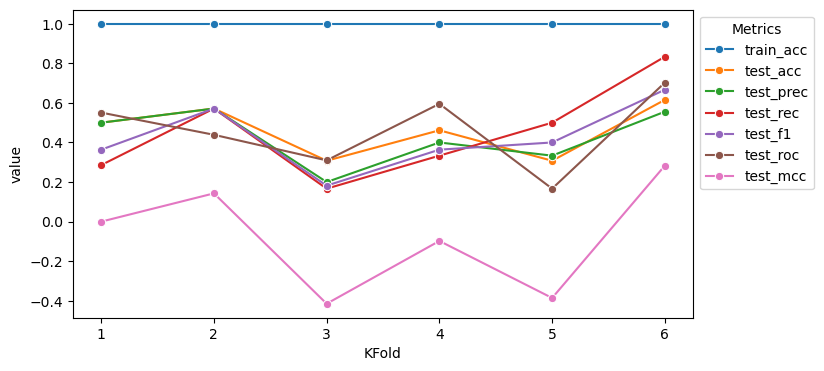

In [434]:
# Plot the Cross Validation metrics score for visual inspection

crossVal_metrics = ['train_acc','test_acc','test_prec','test_rec','test_f1','test_roc','test_mcc']
crossVal_metrics_scores = []

# Add Kfold 
kfolds = np.arange(1,_KFold+1)
crossVal_metrics_scores.append(kfolds)

for metric in crossVal_metrics:
    #print(np.ravel(scores[metric]))
    crossVal_metrics_scores.append(scores[metric])

dfm = pd.DataFrame(zip(*crossVal_metrics_scores), columns = ['KFold']+crossVal_metrics).set_index('KFold')

#dfm.to_csv('kfold_metrics.csv', sep=';', encoding='utf-8', index=True, header=True)

dfplt = dfm.melt(ignore_index=False).reset_index()

#dfplt

# set the figure height and width
fig, ax = plt.subplots(figsize=(8, 4))

# plot with seaborn
sns.lineplot(ax=ax, data=dfplt, x='KFold', y='value', hue='variable', marker='o')
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title='Metrics');
plt.xticks(np.arange(1, _KFold+1))

plt.show();


In [435]:
# Model Evaluation Metrics Mean Scores

ml_metrics = {
    'Accuracy on Training Data':'{:.2f}'.format(np.mean(dfm['train_acc'])),#.format(pipe.score(x_train, y_train)), 
    'Accuracy on Test Data':'{:.2f}'.format(np.mean(dfm['test_acc'])),#.format(pipe.score(x_test, y_test)), 
    'Precision of Classifier on Test Data':'{:.2f}'.format(np.mean(dfm['test_prec'])),
    'Recall of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_rec'])),
    'F1 of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_f1'])),
    'ROC AUC Score of Classifier on Test Data':'{:.2f}%'.format(np.mean(dfm['test_roc'])*100),
    'MCC Coefficient': '{:.5f}'.format(np.mean(dfm['test_mcc'])),
}
df = pd.DataFrame.from_dict(ml_metrics, orient='index',
                       columns=['Random Forest'])
metrics_list.append(df)
df


,Random Forest
Accuracy on Training Data,1.00
Accuracy on Test Data,0.46
Precision of Classifier on Test Data,0.43
Recall of Classifier on Test Data,0.44841
F1 of Classifier on Test Data,0.42453
ROC AUC Score of Classifier on Test Data,46.06%
MCC Coefficient,-0.07873


In [436]:
# Produce the Cross Validation Confusion Metrix

y_pred = cross_val_predict(grid_search.best_estimator_, x, np.ravel(y, order='C'), cv=_KFold)
conf_mat = confusion_matrix(y, y_pred)

conf_mat


array([[19, 23],
       [22, 16]])

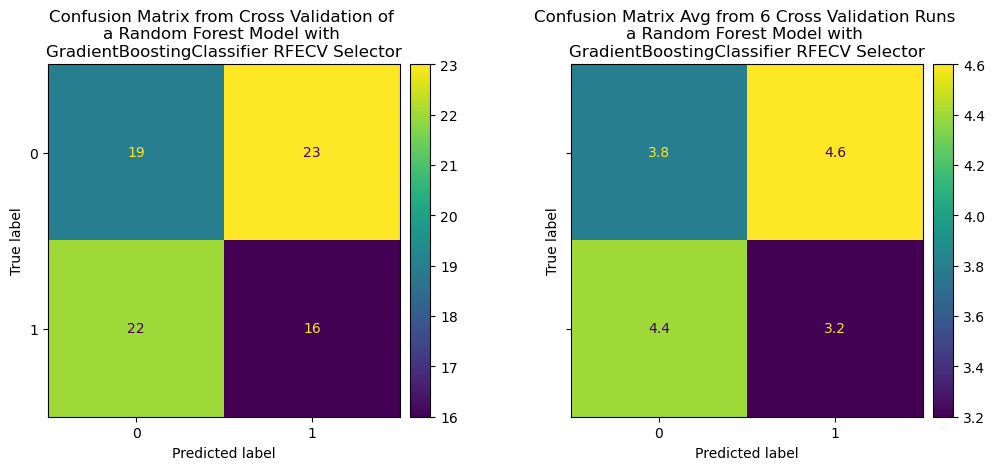

In [437]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplots(figsize=(10, 10), ncols=2, sharex=True, sharey=True)

# Plot total sum of all folds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[0], colorbar=False)
disp.ax_.set_title('Confusion Matrix from Cross Validation of \na Random Forest Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[0].get_position().x1+0.01, axs[0].get_position().y0, 0.02, axs[0].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

#Plot Avg values per _KFold rounds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat/(_KFold-1), display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[1], colorbar=False)
disp.ax_.set_title(f'Confusion Matrix Avg from {_KFold} Cross Validation Runs \na Random Forest Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[1].get_position().x1+0.01, axs[1].get_position().y0, 0.02, axs[1].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

bbox = axs[1].get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
axs[1].set_position(new_bbox)

bbox = cax.get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
cax.set_position(new_bbox)

plt.show();

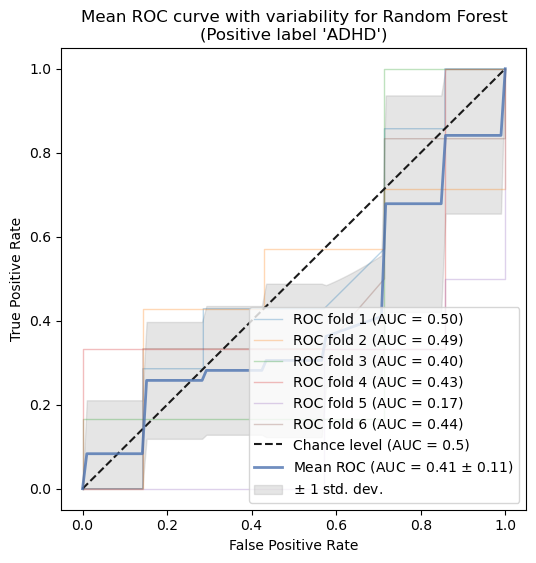

In [438]:
# Plot Cross Validation ROC AUC

classifier = grid_search.best_estimator_
n_splits = _KFold
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6)) #, nrows=7
for fold, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold+1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability for Random Forest\n(Positive label 'ADHD')",
)
ax.legend(loc="lower right")

# Hide any unused subplots
# ax = ax.flatten()
# for i, aax in enumerate(ax):
#     # print(i)
#     if i != 6:
#         aax.set_visible(False)
    
plt.show();

### 3- K-Nearest Neighbors (KNN)

In [175]:
%%time

#3
# KNN

clf = KNeighborsClassifier() #random_state=0
pipe_knn = Pipeline([("preprocessor", preprocessor),
                 ("selector", feature_selector), 
                 ("classifier", clf)])

# Make code modular
pipe = pipe_knn

grid_params = {'classifier__'+k: v for k, v in _PARAMS_KNN.items()}

grid_search_knn = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=_NUMBER_OF_FOLDS, n_jobs=-1, verbose=True, refit=True, scoring='r2')

# Make code modular
grid_search = grid_search_knn

grid_search.fit(x_train, np.ravel(y_train, order='C'))


Fitting 5 folds for each of 160 candidates, totalling 800 fits
CPU times: user 30.1 s, sys: 3.68 s, total: 33.8 s
Wall time: 42min 12s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_categoricals',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(categories=[['1',
                                                                                                                      '2',
                                                                                                                      '3',
                                                                                                                      '4']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-999)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())...
                                                                          'lf_hf_ratio_HRV', ...])])),
                                       ('selector',
                                        RFECV(estimator=GradientBoostingClassifier())),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__algorithm': ['auto', 'ball_tree',
                                                   'kd_tree', 'brute'],
                         'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='r2', verbose=True)

In [177]:

# summarize Best Estimator
print('=========================================[Best Hyperparameters info]=====================================')
print('Best Score: %.3f'  % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
print('Best_estimator:')
print(grid_search.best_estimator_)
print('==========================================================================================================')

predictions_knn = grid_search.predict(x_test)
predictions_train_knn = grid_search.predict(x_train)

# Make code modular
predictions = predictions_knn
predictions_train = predictions_train_knn

=========================================[Best Hyperparameters info]=====================================
Best Score: -0.767
Best Config: {'classifier__algorithm': 'kd_tree', 'classifier__n_neighbors': 6, 'classifier__p': 2, 'classifier__weights': 'uniform'}
Best_estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_categoricals',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['1',
                                                                                               '2',
       

In [439]:
%%time
# cross Validate the model metrics

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'roc':'roc_auc',
           'mcc':'matthews_corrcoef',
           'f1':'f1',
          }


scores_knn = cross_validate(grid_search.best_estimator_, x, np.ravel(y, order='C'), scoring=scoring, #grid_search or pipe or clf
                         cv=_KFold, return_train_score=True) #takes multiple metrics

# Make code modular
scores = scores_knn

print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec', 'train_prec', 'test_rec', 'train_rec', 'test_roc', 'train_roc', 'test_mcc', 'train_mcc', 'test_f1', 'train_f1'])
CPU times: user 1min 47s, sys: 230 ms, total: 1min 47s
Wall time: 1min 47s


In [440]:
# check metric lists
print('train_acc: ',scores['train_acc'])
print('test_acc: ',scores['test_acc'])
print('test_prec: ',scores['test_prec'])
print('test_rec: ',scores['test_rec'])
print('test_f1: ',scores['test_f1'])
print('test_roc: ',scores['test_roc'])
print('test_mcc: ',scores['test_mcc'])

train_acc:  [0.68181818 0.63636364 0.73134328 0.62686567 0.7761194  0.6119403 ]
test_acc:  [0.64285714 0.28571429 0.53846154 0.61538462 0.30769231 0.38461538]
test_prec:  [1.         0.         0.5        0.57142857 0.28571429 0.33333333]
test_rec:  [0.28571429 0.         0.16666667 0.66666667 0.33333333 0.33333333]
test_f1:  [0.44444444 0.         0.25       0.61538462 0.30769231 0.33333333]
test_roc:  [0.65306122 0.32653061 0.45238095 0.54761905 0.4047619  0.39285714]
test_mcc:  [ 0.40824829 -0.52223297  0.03289758  0.23809524 -0.38095238 -0.23809524]


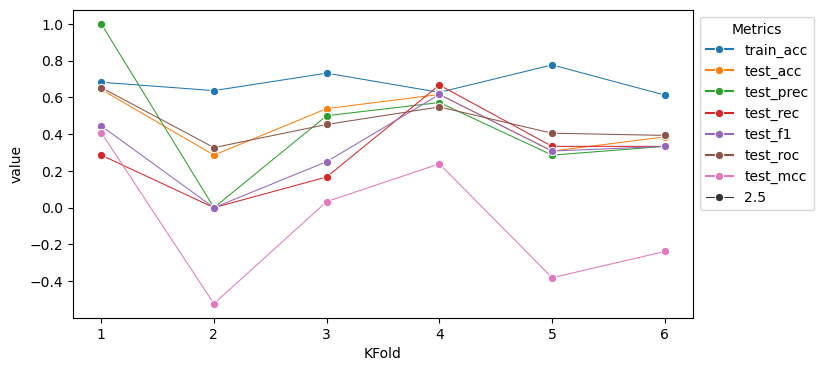

In [443]:
# Plot the Cross Validation metrics

crossVal_metrics = ['train_acc','test_acc','test_prec','test_rec','test_f1','test_roc','test_mcc']
crossVal_metrics_scores = []

# Add Kfold 
kfolds = np.arange(1,_KFold+1)
crossVal_metrics_scores.append(kfolds)

for metric in crossVal_metrics:
    #print(np.ravel(scores[metric]))
    crossVal_metrics_scores.append(scores[metric])

dfm = pd.DataFrame(zip(*crossVal_metrics_scores), columns = ['KFold']+crossVal_metrics).set_index('KFold')

#dfm.to_csv('kfold_metrics.csv', sep=';', encoding='utf-8', index=True, header=True)

dfplt = dfm.melt(ignore_index=False).reset_index()

#dfplt

# set the figure height and width
fig, ax = plt.subplots(figsize=(8, 4))

# plot with seaborn
sns.lineplot(ax=ax, data=dfplt, x='KFold', y='value', hue='variable', size=2.5, marker='o')
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title='Metrics');
plt.xticks(np.arange(1, _KFold+1))

plt.show();


In [444]:
# Model Evaluation Metrics Mean Scores

ml_metrics = {
    'Accuracy on Training Data':'{:.2f}'.format(np.mean(dfm['train_acc'])),#.format(pipe.score(x_train, y_train)), 
    'Accuracy on Test Data':'{:.2f}'.format(np.mean(dfm['test_acc'])),#.format(pipe.score(x_test, y_test)), 
    'Precision of Classifier on Test Data':'{:.2f}'.format(np.mean(dfm['test_prec'])),
    'Recall of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_rec'])),
    'F1 of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_f1'])),
    'ROC AUC Score of Classifier on Test Data':'{:.2f}%'.format(np.mean(dfm['test_roc'])*100),
    'MCC Coefficient': '{:.5f}'.format(np.mean(dfm['test_mcc'])),
}
df = pd.DataFrame.from_dict(ml_metrics, orient='index',
                       columns=['KNN'])
metrics_list.append(df)
df


,KNN
Accuracy on Training Data,0.68
Accuracy on Test Data,0.46
Precision of Classifier on Test Data,0.45
Recall of Classifier on Test Data,0.29762
F1 of Classifier on Test Data,0.32514
ROC AUC Score of Classifier on Test Data,46.29%
MCC Coefficient,-0.07701


In [445]:
# Produce the Cross Validation Confusion Metrix

y_pred = cross_val_predict(grid_search.best_estimator_, x, np.ravel(y, order='C'), cv=_KFold)
conf_mat = confusion_matrix(y, y_pred)

conf_mat


array([[32, 10],
       [30,  8]])

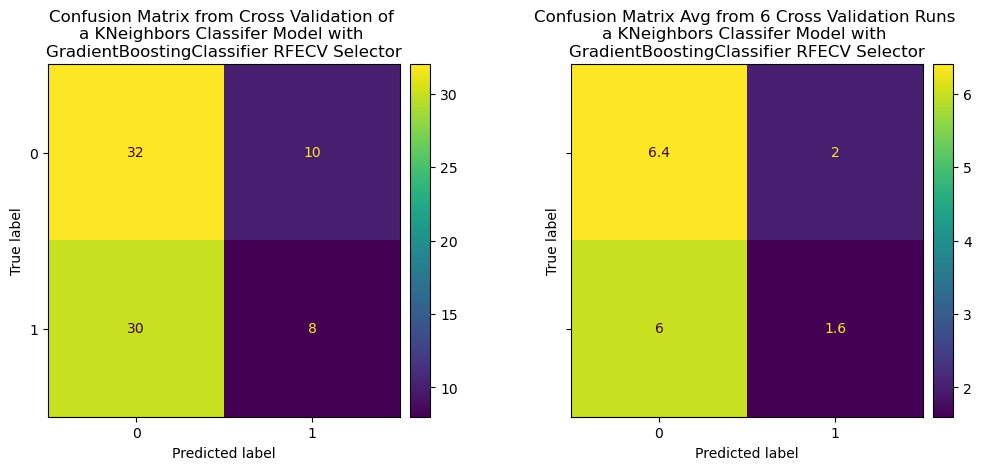

In [446]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplots(figsize=(10, 10), ncols=2, sharex=True, sharey=True)

# Plot total sum of all folds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[0], colorbar=False)
disp.ax_.set_title('Confusion Matrix from Cross Validation of \na KNeighbors Classifer Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[0].get_position().x1+0.01, axs[0].get_position().y0, 0.02, axs[0].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

#Plot Avg values per _KFold rounds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat/(_KFold-1), display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[1], colorbar=False)
disp.ax_.set_title(f'Confusion Matrix Avg from {_KFold} Cross Validation Runs \na KNeighbors Classifer Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[1].get_position().x1+0.01, axs[1].get_position().y0, 0.02, axs[1].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

bbox = axs[1].get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
axs[1].set_position(new_bbox)

bbox = cax.get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
cax.set_position(new_bbox)

plt.show();

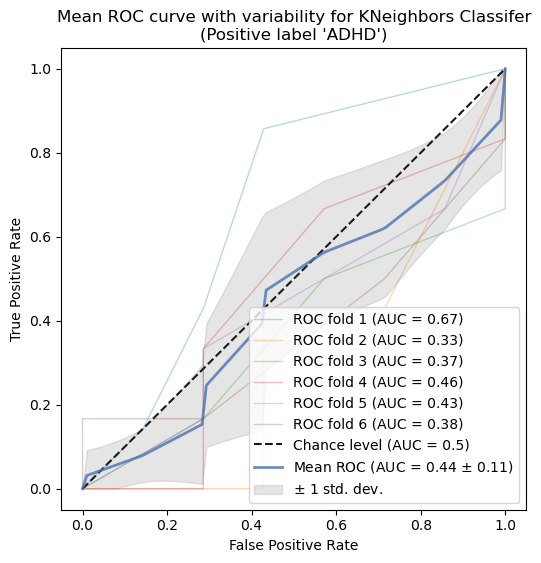

In [447]:
# Plot Cross Validation ROC AUC

classifier = grid_search.best_estimator_
n_splits = _KFold
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6)) #, nrows=7
for fold, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold+1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability for KNeighbors Classifer\n(Positive label 'ADHD')",
)
ax.legend(loc="lower right")

# Hide any unused subplots
# ax = ax.flatten()
# for i, aax in enumerate(ax):
#     # print(i)
#     if i != 6:
#         aax.set_visible(False)
    
plt.show();

### 4- XGBoost

In [185]:
%%time

#4
# XGBoost

clf = xgb.XGBClassifier() #random_state=0
pipe_xgb = Pipeline([("preprocessor", preprocessor),
                 ("selector", feature_selector), 
                 ("classifier", clf)])

# Make code modular
pipe = pipe_xgb

grid_params = {'classifier__'+k: v for k, v in _PARAMS_XGB.items()}
grid_search_xgb = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=_NUMBER_OF_FOLDS, n_jobs=-1, verbose=True, refit=True, scoring='r2')

# Make code modular
grid_search = grid_search_xgb

grid_search.fit(x_train, np.ravel(y_train, order='C'))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
CPU times: user 34.4 s, sys: 4.69 s, total: 39.1 s
Wall time: 1h 18min 55s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_categoricals',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(categories=[['1',
                                                                                                                      '2',
                                                                                                                      '3',
                                                                                                                      '4']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-999)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())...
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1, 0.01, 0.05],
                         'classifier__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'classifier__n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                         'classifier__objective': ['binary:logistic'],
                         'classifier__random_state': [0],
                         'classifier__verbosity': [0]},
             scoring='r2', verbose=True)

In [187]:

# summarize Best Estimator
print('=========================================[Best Hyperparameters info]=====================================')
print('Best Score: %.3f'  % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
print('Best_estimator:')
print(grid_search.best_estimator_)
print('==========================================================================================================')

predictions_xgb = grid_search.predict(x_test)
predictions_train_xgb = grid_search.predict(x_train)

# Make code modular
predictions = predictions_xgb
predictions_train = predictions_train_xgb

=========================================[Best Hyperparameters info]=====================================
Best Score: -0.943
Best Config: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__objective': 'binary:logistic', 'classifier__random_state': 0, 'classifier__verbosity': 0}
Best_estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_categoricals',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['1',
                            

In [448]:
%%time
# cross Validate the model metrics

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'roc':'roc_auc',
           'mcc':'matthews_corrcoef',
           'f1':'f1',
          }

scores_xgb = cross_validate(grid_search.best_estimator_, x, np.ravel(y, order='C'), scoring=scoring, #grid_search or pipe or clf
                         cv=_KFold, return_train_score=True) #takes multiple metrics

# Make code modular
scores = scores_xgb

print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_acc', 'train_acc', 'test_prec', 'train_prec', 'test_rec', 'train_rec', 'test_roc', 'train_roc', 'test_mcc', 'train_mcc', 'test_f1', 'train_f1'])
CPU times: user 2min 7s, sys: 1.02 s, total: 2min 8s
Wall time: 1min 46s


In [449]:
# Inspect Cross Validation Metrics Scores lists
print('train_acc: ',scores['train_acc'])
print('test_acc: ',scores['test_acc'])
print('test_prec: ',scores['test_prec'])
print('test_rec: ',scores['test_rec'])
print('test_f1: ',scores['test_f1'])
print('test_roc: ',scores['test_roc'])
print('test_mcc: ',scores['test_mcc'])

train_acc:  [1. 1. 1. 1. 1. 1.]
test_acc:  [0.42857143 0.57142857 0.30769231 0.69230769 0.30769231 0.46153846]
test_prec:  [0.33333333 0.6        0.28571429 0.66666667 0.2        0.44444444]
test_rec:  [0.14285714 0.42857143 0.33333333 0.66666667 0.16666667 0.66666667]
test_f1:  [0.2        0.5        0.30769231 0.66666667 0.18181818 0.53333333]
test_roc:  [0.53061224 0.53061224 0.35714286 0.66666667 0.16666667 0.61904762]
test_mcc:  [-0.17407766  0.1490712  -0.38095238  0.38095238 -0.41475753 -0.05143445]


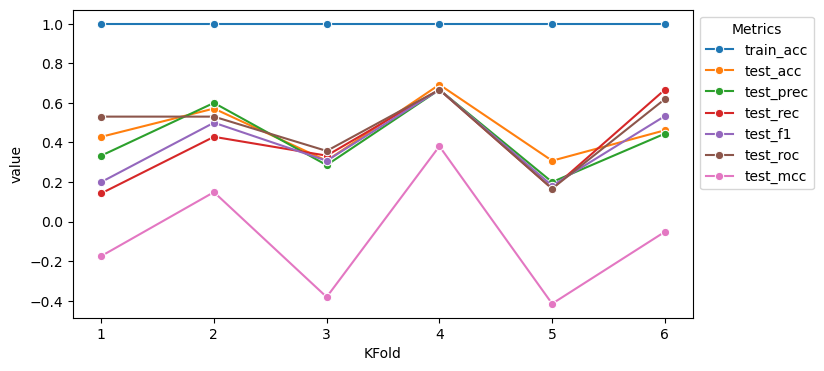

In [450]:
# Plot the Cross Validation metrics

crossVal_metrics = ['train_acc','test_acc','test_prec','test_rec','test_f1','test_roc','test_mcc']
crossVal_metrics_scores = []

# Add Kfold 
kfolds = np.arange(1,_KFold+1)
crossVal_metrics_scores.append(kfolds)

for metric in crossVal_metrics:
    #print(np.ravel(scores[metric]))
    crossVal_metrics_scores.append(scores[metric])

dfm = pd.DataFrame(zip(*crossVal_metrics_scores), columns = ['KFold']+crossVal_metrics).set_index('KFold')

#dfm.to_csv('kfold_metrics.csv', sep=';', encoding='utf-8', index=True, header=True)

dfplt = dfm.melt(ignore_index=False).reset_index()

#dfplt

# set the figure height and width
fig, ax = plt.subplots(figsize=(8, 4))

# plot with seaborn
sns.lineplot(ax=ax, data=dfplt, x='KFold', y='value', hue='variable', marker='o')
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title='Metrics');
plt.xticks(np.arange(1, _KFold+1))

plt.show();


In [451]:
# Model Evaluation Metrics Mean Scores

ml_metrics = {
    'Accuracy on Training Data':'{:.2f}'.format(np.mean(dfm['train_acc'])),#.format(pipe.score(x_train, y_train)), 
    'Accuracy on Test Data':'{:.2f}'.format(np.mean(dfm['test_acc'])),#.format(pipe.score(x_test, y_test)), 
    'Precision of Classifier on Test Data':'{:.2f}'.format(np.mean(dfm['test_prec'])),
    'Recall of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_rec'])),
    'F1 of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_f1'])),
    'ROC AUC Score of Classifier on Test Data':'{:.2f}%'.format(np.mean(dfm['test_roc'])*100),
    'MCC Coefficient': '{:.5f}'.format(np.mean(dfm['test_mcc'])),
}
df = pd.DataFrame.from_dict(ml_metrics, orient='index',
                       columns=['XGBoost'])
metrics_list.append(df)
df


,XGBoost
Accuracy on Training Data,1.00
Accuracy on Test Data,0.46
Precision of Classifier on Test Data,0.42
Recall of Classifier on Test Data,0.40079
F1 of Classifier on Test Data,0.39825
ROC AUC Score of Classifier on Test Data,47.85%
MCC Coefficient,-0.08187


In [452]:
# Produce the Cross Validation Confusion Metrix

y_pred = cross_val_predict(grid_search.best_estimator_, x, np.ravel(y, order='C'), cv=_KFold)
conf_mat = confusion_matrix(y, y_pred)

conf_mat


array([[22, 20],
       [26, 12]])

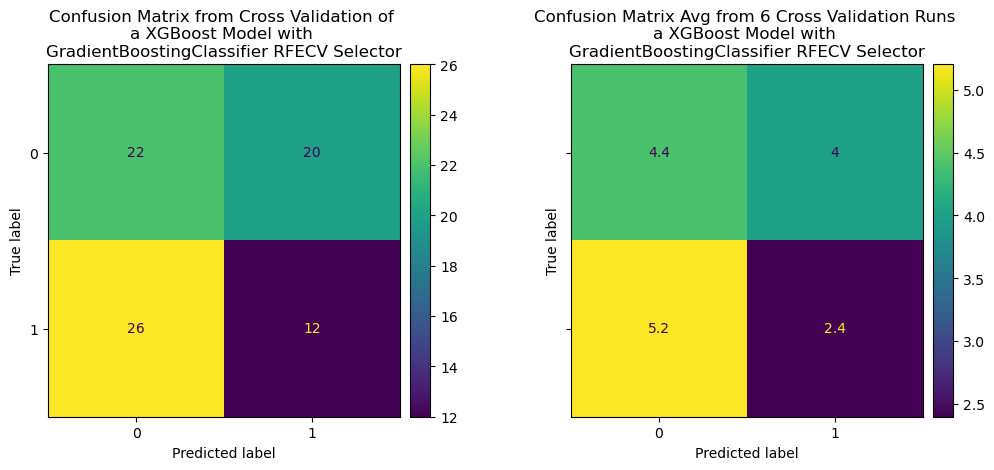

In [453]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplots(figsize=(10, 10), ncols=2, sharex=True, sharey=True)

# Plot total sum of all folds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[0], colorbar=False)
disp.ax_.set_title('Confusion Matrix from Cross Validation of \na XGBoost Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[0].get_position().x1+0.01, axs[0].get_position().y0, 0.02, axs[0].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

#Plot Avg values per _KFold rounds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat/(_KFold-1), display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[1], colorbar=False)
disp.ax_.set_title(f'Confusion Matrix Avg from {_KFold} Cross Validation Runs \na XGBoost Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[1].get_position().x1+0.01, axs[1].get_position().y0, 0.02, axs[1].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

bbox = axs[1].get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
axs[1].set_position(new_bbox)

bbox = cax.get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
cax.set_position(new_bbox)

plt.show();

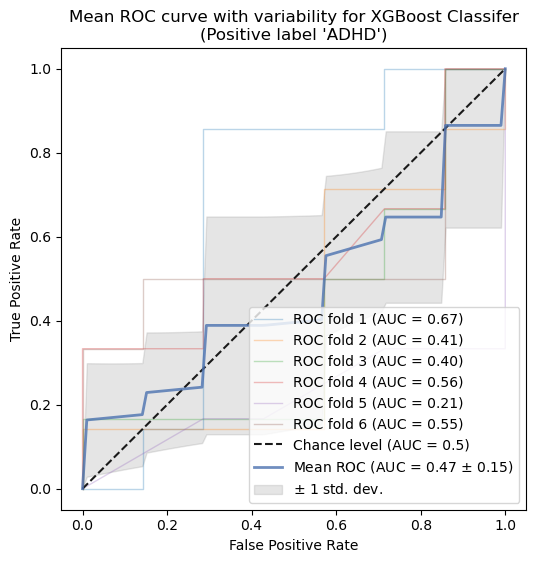

In [454]:
# Plot Cross Validation ROC AUC

classifier = grid_search.best_estimator_
n_splits = _KFold
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6)) #, nrows=7
for fold, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold+1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability for XGBoost Classifer\n(Positive label 'ADHD')",
)
ax.legend(loc="lower right")

# Hide any unused subplots
# ax = ax.flatten()
# for i, aax in enumerate(ax):
#     # print(i)
#     if i != 6:
#         aax.set_visible(False)
    
plt.show();

### 5- Light GBM

In [210]:
%%time

#4
# Light GBM (LGBM) Hyper Parameter Tuning

clf = lgb.LGBMClassifier() #random_state=0
pipe_lgbm = Pipeline([("preprocessor", preprocessor),
                 ("selector", feature_selector), 
                 ("classifier", clf)])

# Make code modular
pipe = pipe_lgbm

grid_params = {'classifier__'+k: v for k, v in _PARAMS_LIGHTGB.items()}
grid_search_lgbm = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=_NUMBER_OF_FOLDS, n_jobs=-1, verbose=True, refit=True, scoring='r2')

# Make code modular
grid_search = grid_search_lgbm

grid_search.fit(x_train, np.ravel(y_train, order='C'))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord_categoricals',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(categories=[['1',
                                                                                                                      '2',
                                                                                                                      '3',
                                                                                                                      '4']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-999)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())...
                                                                          'lf_power_HRV',
                                                                          'hf_power_HRV',
                                                                          'lf_hf_ratio_HRV', ...])])),
                                       ('selector',
                                        RFECV(estimator=GradientBoostingClassifier())),
                                       ('classifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1, 0.03, 0.003],
                         'classifier__max_depth': [-1, 3, 5],
                         'classifier__n_estimators': range(50, 500, 50),
                         'classifier__num_leaves': [7, 14, 21, 28, 31]},
             scoring='r2', verbose=True)

In [276]:

# summarize Best Estimator
print('=========================================[Best Hyperparameters info]=====================================')
print('Best Score: %.3f'  % grid_search.best_score_)
print('Best Config: %s' % grid_search.best_params_)
print('Best_estimator:')
print(grid_search.best_estimator_)
print('==========================================================================================================')

predictions_lgbm = grid_search.predict(x_test)
predictions_train_lgbm = grid_search.predict(x_train)

# Make code modular
predictions = predictions_lgbm
predictions_train = predictions_train_lgbm

=========================================[Best Hyperparameters info]=====================================
Best Score: -0.629
Best Config: {'classifier__learning_rate': 0.003, 'classifier__max_depth': -1, 'classifier__n_estimators': 450, 'classifier__num_leaves': 7}
Best_estimator:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord_categoricals',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['1',
                                                                                               '2',


In [ ]:
%%time
# cross Validate the model metrics

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'roc':'roc_auc',
           'mcc':'matthews_corrcoef',
           'f1':'f1',
          }

scores_lgbm = cross_validate(grid_search.best_estimator_, x, np.ravel(y, order='C'), scoring=scoring, #grid_search or pipe or clf
                         cv=_KFold, return_train_score=True) #takes multiple metrics

# Make code modular
scores = scores_lgbm

print(scores.keys())

In [456]:
# inspect metrics lists
print('train_acc: ',scores['train_acc'])
print('test_acc: ',scores['test_acc'])
print('test_prec: ',scores['test_prec'])
print('test_rec: ',scores['test_rec'])
print('test_f1: ',scores['test_f1'])
print('test_roc: ',scores['test_roc'])
print('test_mcc: ',scores['test_mcc'])

train_acc:  [0.65151515 0.65151515 0.59701493 0.56716418 0.70149254 0.74626866]
test_acc:  [0.5        0.5        0.46153846 0.69230769 0.38461538 0.46153846]
test_prec:  [0.5        0.5        0.4        0.66666667 0.25       0.44444444]
test_rec:  [0.14285714 0.57142857 0.33333333 0.66666667 0.16666667 0.66666667]
test_f1:  [0.22222222 0.53333333 0.36363636 0.66666667 0.2        0.53333333]
test_roc:  [0.65306122 0.46938776 0.5        0.66666667 0.28571429 0.46428571]
test_mcc:  [ 0.          0.         -0.09759001  0.38095238 -0.28288947 -0.05143445]


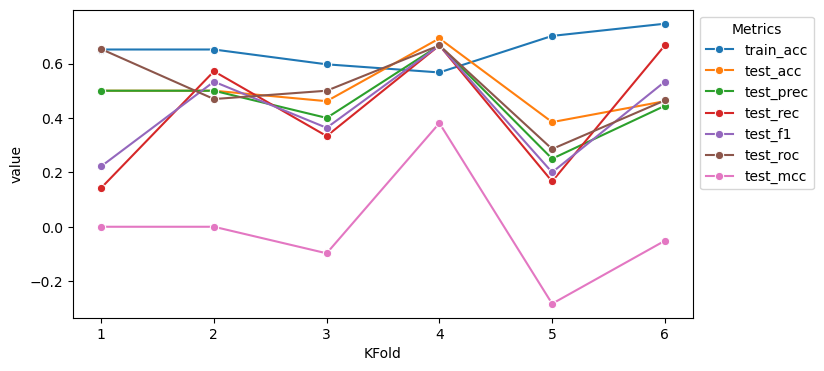

In [457]:
# Plot the Cross Validation metrics for visual inspection

crossVal_metrics = ['train_acc','test_acc','test_prec','test_rec','test_f1','test_roc','test_mcc']
crossVal_metrics_scores = []

# Add Kfold 
kfolds = np.arange(1,_KFold+1)
crossVal_metrics_scores.append(kfolds)

for metric in crossVal_metrics:
    #print(np.ravel(scores[metric]))
    crossVal_metrics_scores.append(scores[metric])

dfm = pd.DataFrame(zip(*crossVal_metrics_scores), columns = ['KFold']+crossVal_metrics).set_index('KFold')

#dfm.to_csv('kfold_metrics.csv', sep=';', encoding='utf-8', index=True, header=True)

dfplt = dfm.melt(ignore_index=False).reset_index()

#dfplt

# set the figure height and width
fig, ax = plt.subplots(figsize=(8, 4))

# plot with seaborn
sns.lineplot(ax=ax, data=dfplt, x='KFold', y='value', hue='variable', marker='o')
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title='Metrics');
plt.xticks(np.arange(1, _KFold+1))

plt.show();


In [458]:
# Model Evaluation Metrics Scores

ml_metrics = {
    'Accuracy on Training Data':'{:.2f}'.format(np.mean(dfm['train_acc'])),#.format(pipe.score(x_train, y_train)), 
    'Accuracy on Test Data':'{:.2f}'.format(np.mean(dfm['test_acc'])),#.format(pipe.score(x_test, y_test)), 
    'Precision of Classifier on Test Data':'{:.2f}'.format(np.mean(dfm['test_prec'])),
    'Recall of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_rec'])),
    'F1 of Classifier on Test Data':'{:.5f}'.format(np.mean(dfm['test_f1'])),
    'ROC AUC Score of Classifier on Test Data':'{:.2f}%'.format(np.mean(dfm['test_roc'])*100),
    'MCC Coefficient': '{:.5f}'.format(np.mean(dfm['test_mcc'])),
}
df = pd.DataFrame.from_dict(ml_metrics, orient='index',
                       columns=['LightGBM'])
metrics_list.append(df)
df


,LightGBM
Accuracy on Training Data,0.65
Accuracy on Test Data,0.50
Precision of Classifier on Test Data,0.46
Recall of Classifier on Test Data,0.42460
F1 of Classifier on Test Data,0.41987
ROC AUC Score of Classifier on Test Data,50.65%
MCC Coefficient,-0.00849


In [459]:
# Produce the Cross Validation Confusion Metrix

y_pred = cross_val_predict(grid_search.best_estimator_, x, np.ravel(y, order='C'), cv=_KFold)
conf_mat = confusion_matrix(y, y_pred)

conf_mat


[LightGBM] [Info] Number of positive: 32, number of negative: 35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 67, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477612 -> initscore=-0.089612
[LightGBM] [Info] Start training from score -0.089612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

array([[21, 21],
       [23, 15]])

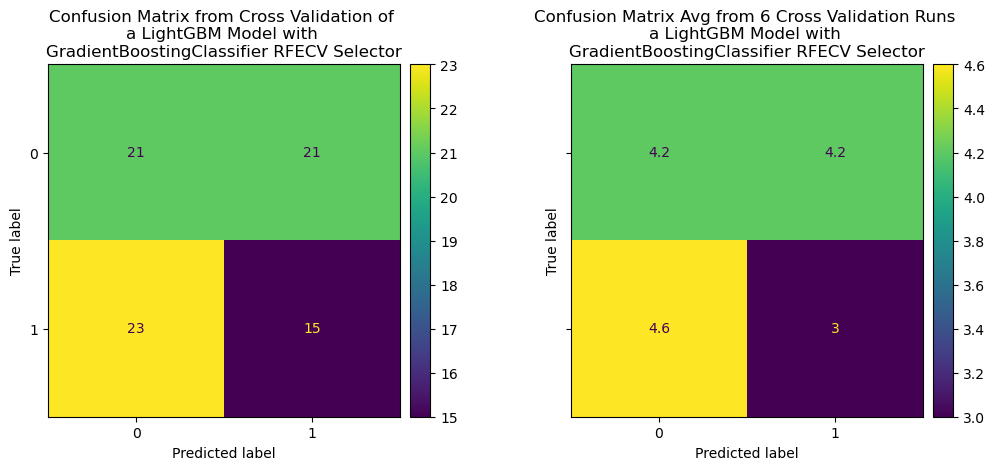

In [460]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplots(figsize=(10, 10), ncols=2, sharex=True, sharey=True)

# Plot total sum of all folds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[0], colorbar=False)
disp.ax_.set_title('Confusion Matrix from Cross Validation of \na LightGBM Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[0].get_position().x1+0.01, axs[0].get_position().y0, 0.02, axs[0].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

#Plot Avg values per _KFold rounds
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat/(_KFold-1), display_labels=grid_search.best_estimator_.classes_)
disp.plot(ax=axs[1], colorbar=False)
disp.ax_.set_title(f'Confusion Matrix Avg from {_KFold} Cross Validation Runs \na LightGBM Model with \nGradientBoostingClassifier RFECV Selector')
# Adding custom colorbar
cax = fig.add_axes([axs[1].get_position().x1+0.01, axs[1].get_position().y0, 0.02, axs[1].get_position().height])
plt.colorbar(disp.im_,  cax=cax)

bbox = axs[1].get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
axs[1].set_position(new_bbox)

bbox = cax.get_position()
new_bbox = (bbox.x0+0.1, bbox.y0, bbox.width, bbox.height)
cax.set_position(new_bbox)

plt.show();

[LightGBM] [Info] Number of positive: 32, number of negative: 35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 67, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477612 -> initscore=-0.089612
[LightGBM] [Info] Start training from score -0.089612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

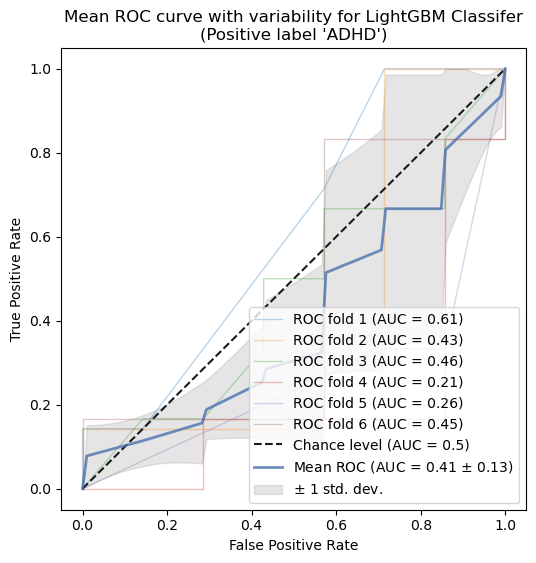

In [461]:
# Plot Cross Validation ROC AUC

classifier = grid_search.best_estimator_
n_splits = _KFold
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6)) #, nrows=7
for fold, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold+1}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability for LightGBM Classifer\n(Positive label 'ADHD')",
)
ax.legend(loc="lower right")

# Hide any unused subplots
# ax = ax.flatten()
# for i, aax in enumerate(ax):
#     # print(i)
#     if i != 6:
#         aax.set_visible(False)

plt.show();

In [ ]:
# Combine Metrics Mean Scores

In [464]:
# construct dfeval dataframe to combine evaluation metrics from different models
dfeval = pd.concat(metrics_list[2:], axis=1, ignore_index=False)

In [465]:
#dfm=dfm.iloc[:,[0,1,5,6,7]]
dfeval.T

,Accuracy on Training Data,Accuracy on Test Data,Precision of Classifier on Test Data,Recall of Classifier on Test Data,F1 of Classifier on Test Data,ROC AUC Score of Classifier on Test Data,MCC Coefficient
Logistic Regression,0.68,0.63,0.64,0.55952,0.58974,62.64%,0.25940
Random Forest,1.00,0.46,0.43,0.44841,0.42453,46.06%,-0.07873
KNN,0.68,0.46,0.45,0.29762,0.32514,46.29%,-0.07701
XGBoost,1.00,0.46,0.42,0.40079,0.39825,47.85%,-0.08187
LightGBM,0.65,0.50,0.46,0.42460,0.41987,50.65%,-0.00849


In [479]:
# save table to csv
dfeval.T.to_csv('models_evaluation_gridSearchCV_CrossVal.csv', sep=';', encoding='utf-8', index=True, header=True)